# Data Science Perspective on Predicting Residential Real Estate Prices by John Foxworthy

### Abstract

What drives the price of housing? Are there any characteristics that explain price behavior? How can we predict the next price?
For this project, I use a Data Science perspective, which applies statistical techniques to a business case with some tools of software development, especially Python. The chosen data set is for demonstration purposes only and comes from https://www.zillow.com/research/data/ , which is seasonally adjusted. Narrative analytics from the Exploratory Data Analysis will drive the argument for the model selection. AutoRegressive Integrated Moving Average (ARIMA) will be implemented followed by Exponential Smoothing to make prediction of next month's price.  Lastly, ARIMA is revisted with additional parameters to a make another prediction with SARIMAX.  

### Introduction

The median sale price has no assumptions how each property sale price is grouped or distributed. By taking the middle number of a particular month we can have the best representation of a monthly dataset. An arithmetic average would be bias as the distribution of all the sale prices vary from one month to the next.

For example, if a small series of months have a majority of sale prices on the lower end of values with a minority count on the higher end, then an average would underrepresent the higher end values and overrepresent the more common lower end values. Conversely, higher end values with a smaller count on the lower end would underrepresent the lower end values and overrepresent the more common higher end values. The median, however, does a better job in capturing the skewness of data over seveal months of time because it does not treat each datapoint equally by dividing the overall count.

We begin, first by loading the data and we will see how skewness is a central theme to this project to capture the central tendency of the sale price of residential real estate . . . thereafter to eventually predict the next month's median sale price. Below is an outline of the project.

### I. Importing the Time Series Data

### II. Exploratory Data Analysis

### III. Setting Up ARIMA

### IV. ARIMA Model

### V. Workaround with Exponential Smoothing

### VI Improving ARIMA with SARIMAX

### VII. Conclusion

### VIII. Appendix

In [1]:
# Required General Libaries to Import 
import sys
import warnings
from datetime import datetime
import datetime as dt

# Data Science Analytics Libraries
import numpy as np
import pandas as pd
from scipy import stats

# Data Visualization Libaries 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Remove annoying warnings
import warnings
warnings.filterwarnings("ignore")

# I. Importing the Time Series Data

In [2]:
# load data
df = pd.read_csv('/Users/lacivert/re/data.csv')

df = pd.DataFrame(df)

list(df.columns.values)

['Month', 'San_Francisco_Median_Price']

In [3]:
# Clean up missing values 
df.dropna(how='any', inplace=True)

In [4]:
# Descriptive Statistics Table
pd.options.display.float_format = '{:,.0f}'.format # Limit output to no decimal places
df.describe()

,San_Francisco_Median_Price
count,273
mean,"827,262"
std,"356,098"
min,"258,100"
25%,"593,450"
50%,"790,300"
75%,"914,800"
max,"1,520,200"


# II. Exploratory Data Analysis

After setting up the data, let's uncover the main characteristics of the time series for analysis before we model. The findings below will drive model selection for prediction and more importantly reject other models. As we will see below the distribution of median sale price has a constant theme.
First, the descriptive statistics above shows the distribution of the data is skewed from the 273 observations from April 1996 to December 2018. Regardless, if you take the average mean value of 827,262 or 790,300 representing 50 percentile, then there is a greater distance of datapoints left of the distribution.

In [5]:
# Assign variables for analysis 
sf = df.loc[:,'San_Francisco_Median_Price']

In [6]:
np.percentile(sf,50) - np.percentile(sf,25), np.percentile(sf,75) - np.percentile(sf,50)

(196850.0, 124500.0)

196,850 is greater than 124,500 so the higher end values are possibly long and sparse, while the lower end values are dense and more common. 

In [7]:
df.mean() - np.percentile(sf,25)

San_Francisco_Median_Price   233,812
dtype: float64

In [8]:
abs(df.mean() - np.percentile(sf,75))

San_Francisco_Median_Price   87,538
dtype: float64

233,812 is greater than 87,538 with the same theme, but exaggerated because of the arithmetic average.

In [9]:
df.mean()

San_Francisco_Median_Price   827,262
dtype: float64

Let us analyze the skewness further with data visualization.

Text(0.5, 1.0, 'Monthly Distplot\nApril 1996 - December 2018')

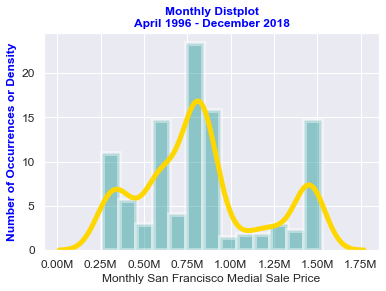

In [10]:
# Histogram of Median Sale Prices

sns.set(style="darkgrid") 
g = sns.distplot(sf, hist=True, axlabel = "Monthly San Francisco Medial Sale Price",  
                 kde_kws={"color": "gold", "lw": 5}, 
                 hist_kws={"linewidth": 5,"color": "darkcyan"})

# Format the horizontal and vertical axes
xlabels = ['{:,.2f}'.format(x) + 'M' for x in g.get_xticks()/1000000]
g.set_xticklabels(xlabels, fontsize=12)

ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()*10000000]
g.set_yticklabels(ylabels, fontsize=12)

# Label and Title 
plt.ylabel('Number of Occurrences or Density',color='blue',weight='bold')
plt.title('Monthly Distplot\nApril 1996 - December 2018', color='blue',weight='bold')

The distplot above with the blue colored discrete histogram and the best fit continuous yellow colored line provides an important level of understanding on the grouping of historical median sale prices and its distribution. Not only do we not have a normal distribution, but there is no gradual increase from the lowest values to the central tendency such as the median from one bucket to the next. Nor do we have gradual decrease from the median to the highest values of the median sale price in San Francisco. Data visualization provides not one, but two humps in the monthly median values.

Let us proceed with statistical metrics below to finish off our case for model selection.

In [11]:
stats.skew(sf)

0.4650429300892724

A positive skew number has the right tail of the distribution is longer than the left, while a normal distrubtion has a zero skew.

In [12]:
stats.kurtosis(sf)

-0.6098890366014929

Pearson definition of kurtosis has a normal distribution of zero and a negative kurtosis means thinner tails. This is troublesome because if we had the opposite, which is fat tails, then we would have room for models with a normal distribution assumption. Tails are a smaller quantity of the overall dataset compared to the larger quantity of the hump. Let's verify if the dataset is normally distributed.

The Shapiro–Wilk tests whether a given time series is normally distributed or not, which is helpful for relatively small sample sizes. The statistical function will return two numbers. The second number is the probability value or p - value and if it is 0.05 or greater then dataset is probably normal. Otherwise, if the p - value less than 0.05, then the dataset is probably not normal. The chance of rejecting the hypothesis when it is true is close to 5% regardless of sample size so we have a 95% level of confidence.

In [13]:
stats.shapiro(sf)

(0.9234578609466553, 1.2414844152708326e-10)

The p - value is very close to zero and therefore less than 0.05 so the data is probably not normal.

Exploratory Data Analysis concludes that the dataset is not normally distributed so models that assume normality will produce inaccurate predictions. Multiple Linear Regression and related models assume a normal distribution so there will be a gap between the predicted values and the observed values, i.e. residuals. There is enough information in the historical median sales price to implement a time series model like ARIMA below.

# III.  Setting up ARIMA

ARIMA assumes historic values dictates the behaviour of the present and the inputted time series data is stationary, i.e. the mean and variance do not change over time. The most common median sales prices of the dataset can produce an arithmetic mean . . . and how the median sale price varies around that mean is the variance. The evolution of a process is a single trend term, which has a linear relationship between time and your outcome. Each step in time, i.e. an additional month, has a changing outcome as our knowledge completes at each iterative step. We look back a certain distance to provide the means to look forward, for one month or one increment. Shocks and outliers fade over time, month by month, as the ARIMA model adjusts and the observable data absorbs the underlying effects of randomness.

We first build ARIMA from an extension of multiple linear regression with differencing to make the time series data stationary. Subtracting each term from the following term, i.e. a single median sale price month from the next one, we build the AR, i.e. the autoregression of ARIMA. Yesterday's outcome based on today's outcome with some left over noise or error term.

Thereafter, the moving average, MA, which changes the focus on the prior error term that leads us to ARMA. If our test results are statistically signficant with tame residuals, then we can proceed to integrate with ARIMA. First, we build a date index to process the model using the Pandas library, pd.

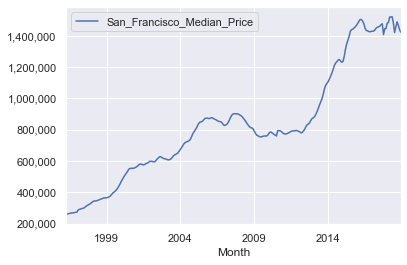

In [14]:
df.index = pd.to_datetime(df.Month)

h = df.plot()
h.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

In [15]:
df.drop(columns=['Month'])

,San_Francisco_Median_Price
Month,
1996-04-01,258100
1996-05-01,260850
1996-06-01,262750
1996-07-01,265000
1996-08-01,267100
1996-09-01,267950
1996-10-01,268350
1996-11-01,269900
1996-12-01,271800


In [16]:
# Adjust the dataframe
df['price'] = pd.to_numeric(df.San_Francisco_Median_Price, errors='coerce')

# sanity check
pd.options.display.float_format = '{:,.0f}'.format # Limit output to no decimal places
df.describe()

,San_Francisco_Median_Price,price
count,273,273
mean,"827,262","827,262"
std,"356,098","356,098"
min,"258,100","258,100"
25%,"593,450","593,450"
50%,"790,300","790,300"
75%,"914,800","914,800"
max,"1,520,200","1,520,200"


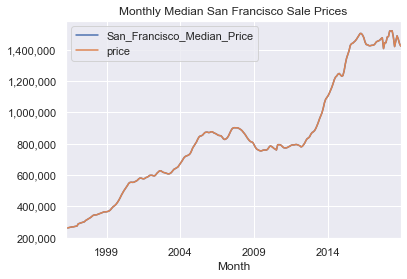

In [17]:
df.index = pd.to_datetime(df.Month)
j = df.plot()
j.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Monthly Median San Francisco Sale Prices')
plt.show()

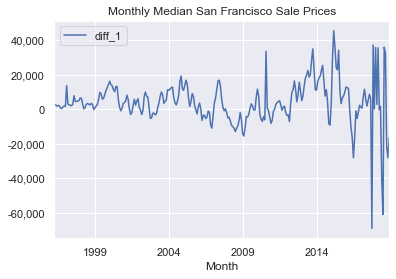

In [18]:
# Plotting the difference 

df['diff_1'] = df.price - df.price.shift()
k = df.plot(y='diff_1')
k.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Monthly Median San Francisco Sale Prices')
plt.show()

Good time series reverting behavior with the differencing above.

Below is the partial autocorrelation function (PACF) that takes the correlation of time series with a lagged version of itself.  The correlation lags are the bars so a PACF of one is the correlation of our first series with itself lagged by one.  The above diff_1 plot mirrors the PACF plot below.

Text(0.5, 1.0, 'Monthly Median San Francisco Sale Price')

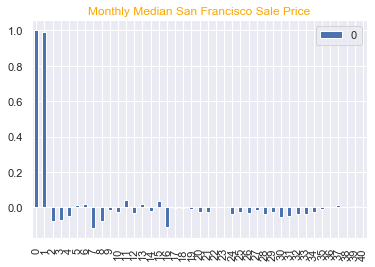

In [19]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(df.price))
x_acf.plot(kind='bar')
plt.title("Monthly Median San Francisco Sale Price", color="orange")

We can conclude the set up for ARIMA as the time sequence is overwhelmingly near zero for all the plots above. The past values are the AR, the level of differencing is I, and adjusting for past errors is MA. Let's first start with ARMA before we run ARIMA.

# IV. ARIMA Model

There are two arguments, which are set up data and the parameter orders. First, is the dataset and second are three variables, which are the number of lag observations, p, the degree of differencing, d and the size of the moving average window, q. A value of 1 for p, d or q indicates in use, while a zero indicates not in use.

In [20]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df.price, order=(1,0,1))
model_fit = model.fit()

print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  273
Model:                     ARMA(1, 1)   Log Likelihood               -2954.915
Method:                       css-mle   S.D. of innovations          11975.183
Date:                Mon, 17 Jun 2019   AIC                           5917.830
Time:                        18:35:52   BIC                           5932.268
Sample:                    04-01-1996   HQIC                          5923.626
                         - 12-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.273e+05   5.47e+05      1.512      0.132   -2.45e+05     1.9e+06
ar.L1.price     0.9996      0.001   1744.401      0.000       0.998       1.001
ma.L1.price     0.3483      0.044      7.972    

The output is more than we need, but we can focus on a few details in the ARMA model above. The p values of AR's ar.L1.price and MA's ma.L1.price are below 0.05 with zero under the P>|z| column.

Let's integrate with ARIMA below.

In [21]:
# ARIMA
model = ARIMA(df.price, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  272
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2919.989
Method:                       css-mle   S.D. of innovations          11112.940
Date:                Mon, 17 Jun 2019   AIC                           5847.979
Time:                        18:35:53   BIC                           5862.402
Sample:                    05-01-1996   HQIC                          5853.769
                         - 12-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4161.8971   1422.402      2.926      0.004    1374.040    6949.754
ar.L1.D.price     0.6614      0.122      5.406      0.000       0.422       0.901
ma.L1.D.price    -0.2818      0.162     

Not good as the p-value greater than 0.05 with 0.084. 

Please note, technically, it is common to view the confidence interval columns of [0.025   0.975] above as indicators, but since ARMIA has a single time series and atheortical it is not relevant here.  

Separately, for example, if we had a Multiple Linear Regression model, then the confidence interval columns are relevant with multiple arrays of data and theoritical underpinnings, i.e. each single array of data would contribute to a prediction.  We do not have an array of data for example like household income to explain the array of the median sale price . . . such as a 1% increase in household income contributing to a $10,000 higher median sale price.  All we have is the single array of monthly median sale prices and any derived properties of it.    

Let's tweak our methodology with weighted averages as the time series have evolving averages over time.

# V. Workaround with Exponential Smoothing

To address a seasonal component in the time series data, the Exponential Smoothing Method takes weighted averages of past observations with an exponentially decreasing weight. In other words, the more recent the observations the higher the associated weight. From a business perspective, recent median sale prices in the past few years in our dataset is of greater signficance than the 1990's because the drivers of price evolve over time. Just another reason to not select a multi-factor model like multiple linear regression.

In [22]:
# Exponential Smoothing data treatment
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# fit model
model_expSm = SimpleExpSmoothing(df.price) 
model_expSm_fit = model_expSm.fit()

# make a prediction
yhat = model_expSm_fit.predict(len(df.price), len(df.price))
print(yhat)

2019-01-01   1,422,000
Freq: MS, dtype: float64


# Next month's San Francisco Median Price is 1,422,000

Text(0.5, 1.0, 'Histogram of Residuals')

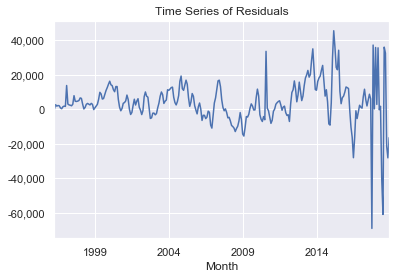

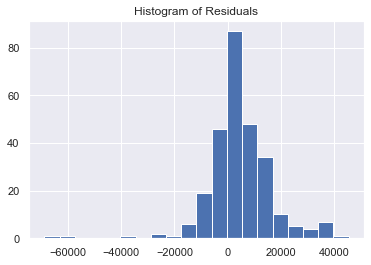

In [23]:
residuals = pd.DataFrame(model_expSm_fit.resid)

n = residuals.plot(legend=False)
n.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Time Series of Residuals')

m = residuals.hist(bins=20)
plt.title('Histogram of Residuals')

A residual data point is the difference between a prediction value and an observed quantity. Altogether, the residuals resemble a normal distribution with the central tendency near zero so very small amounts of both overshooting and undershooting cancel each other out as time progresses. The vast majority of historical residuals is a positive or negative 20,000, which is about two and half percent to the historical median or historical average, i.e. more or less 800,000. We have an acceptable level of error for a predictive model of the median sale price of residential real estate of San Francisco.

# VI. Improving ARIMA with SARIMAX

We can expand our original ARIMA by adding more arguments to better fit the data for prediction.  Going from Time Series Modeling to State Space Modeling, we add a seasonable component to ARIMA for lower winter sales of housing.  Seasonal Autoregressive Integrated Moving Average or SARIMA takes the arguments of p, d and q and adds an additional  layer of P,D and Q with seasonal periods, S.  Functionally, SARIMA (data, p, d, q, P, D, Q, S) with the same ARIMA logic of 1 indicates use and zero not in use.  12 is monthly, 4 is quarterly and 1 is a yearly winter effect for last variable S.

| Description | Variable |
| --- | --- |
| Autoregressive Order | p |
| Difference Order | d |
| Moving Average Order | q |
| Seasonal Autoregressive Order | P |
| Seasonal Difference Order | D |
| Seasonal Moving Average Order | Q |
| Seasonal Periods | S |

Lastly, we add externality, the X, in SARIMAX, and extend the characteristics of our dataset to capture impacts outside of the environment of median sale prices.  Exogenous Regressors models exogenous variables together with the original time series, in the same time sequence to capture observations to be added along the way to the last data point.  We still have a single array of data, the monthly median sale prices, but we replicate to capture properties to find the correct model and tune accordingly.    


In [24]:
# A different implementation
import statsmodels.api as s2

# Choosing the best SARIMAX by running through the argument list
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

To reduce the work of finding the correct argument list of SARIMAX, we use an estimator.  Akaike Information Criterion (AIC) guesses the amount of information lost of a model and gauges the chances of how good or bad of a fit.  

Additionality, the implementation below has the option to remove stationarity of the Autoregressive, AR, of SARMAX, to not assume constant mean and variance of the time series, which was a problem for ARIMA above.  Also, removing invertibility of the moving average, MA, is not needed here so we can increase estimation.   



In [25]:
for parameters in pdq:
    for parameters_seasonal in seasonal_pdq:
        try:
            model2 = s2.tsa.statespace.SARIMAX(df.price,
                                            order=parameters,
                                            seasonal_order=parameters_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model2.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(parameters, parameters_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:8233.378043909877
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7712.784600176106
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6711.455930982833
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6361.3860067781325
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6655.732019303531
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6606.771183840534
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6340.170572507173
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6313.969021100798
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8005.941491951313
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8055.620665429157
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6505.419530184692
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6187.431880615549
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:7646.776157664376
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8050.03391901649
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6228.677141307883
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6180.481399783954
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5912.471915148184
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5654.474805229653
ARIMA(0, 1

/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:5500.676787653973
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:5656.84469172191
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:5894.960492855042
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:5443.767427656244
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:5445.094223765971
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:5849.826008431986
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:5842.538245713716
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:5697.813450341347


/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:7667.341165455079
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:5620.564229298324
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:5837.520679647312
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:5413.978614300951
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:5387.213145994918
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:5837.29763789216
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:5586.350066640456
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:5674.747764656026
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:5375.0854724020755
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:5584.749425803249
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:5586.138578057933
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:5361.392110652245
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:5363.000388200573
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:5811.976608933541
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:5563.103666554347
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:5653.97650652619
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:5354.289831669381
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:5582.815011287563
ARIMA(1, 1,

The last line has the lowest AIC number of 5342 so lets try the argument list of SARIMAX(df.price, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12) and this time shorten the results to focus on the p values of P>|z|.

In [26]:
model2 = s2.tsa.statespace.SARIMAX(df.price,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model2.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6337      0.117      5.406      0.000       0.404       0.863
ma.L1         -0.2013      0.128     -1.575      0.115      -0.452       0.049
ar.S.L12      -0.5803      0.124     -4.678      0.000      -0.823      -0.337
ma.S.L12      -0.0780      0.127     -0.613      0.540      -0.328       0.172
sigma2      1.902e+08    6.2e-10   3.07e+17      0.000     1.9e+08     1.9e+08


We have improved with p values less than 0.05, except the seasonal moving average of ma.S.L12 so let's remove it by putting a zero.

In [27]:
model2b = s2.tsa.statespace.SARIMAX(df.price,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model2b.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5938      0.112      5.294      0.000       0.374       0.814
ma.L1         -0.1470      0.120     -1.224      0.221      -0.382       0.088
ar.S.L12      -0.6390      0.054    -11.919      0.000      -0.744      -0.534
sigma2      1.902e+08   4.68e-10   4.06e+17      0.000     1.9e+08     1.9e+08


All p values less are than 0.05 so we have a model to predict with no seasonal effect on the moving average, Q.

Let's check the residuals calling the plot diagnostics of the same state space model from SARIMAX.  Unlike the Exploratory Data Analysis above with the yellow continuous line, we have better fit of a normal distribution with a green continuous line.  Just like Exponential Smoothing, the gap between the predicted values and observed values are within tolerance.

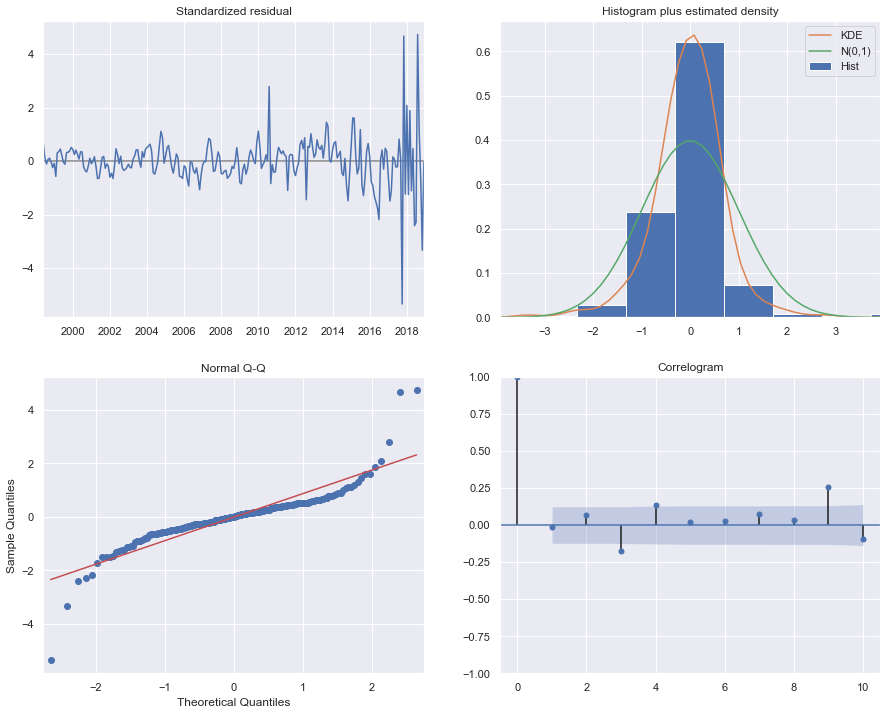

In [28]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Let's visualize the accuracy of our forecast.

In [29]:
# Obtain values within confidence intervals to forecast
predict = results.get_prediction(start=pd.to_datetime('2015-01-01'))
predict_ci = predict.conf_int()

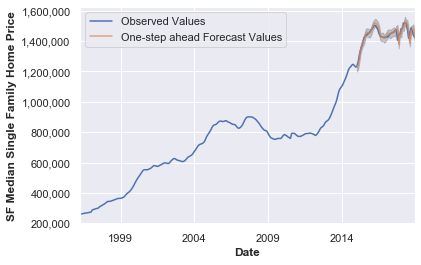

In [30]:
ax = df.price['1996':].plot(label='Observed Values')
predict.predicted_mean.plot(ax=ax, label='One-step ahead Forecast Values', alpha=.7)

ax.fill_between(predict_ci.index,
                predict_ci.iloc[:, 0],
                predict_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date', weight='bold')
ax.set_ylabel('SF Median Single Family Home Price', weight='bold')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.legend()

plt.show()

The original time series and the shaded area above overlap providing us with a good forecast.

In [31]:
# fit model
model2b = s2.tsa.statespace.SARIMAX(df.price, enforce_stationarity=False, enforce_invertibility=False)
model2b_fit = model2b.fit()

# make a prediction
yhat2 = model2b_fit.predict(len(df.price), len(df.price))
print(yhat2)

2019-01-01   1,428,187
Freq: MS, dtype: float64


# Next month's San Francisco Median Price is 1,428,187

# VII. Conclusion

Given the difficult properties of the dataset, we can verify models to use and predict.  Below is a summary . . .

(1) Exploratory Data Analyst shows the complexity of the historical housing sale prices with most of the data in the middle clumped in two sets . . . not only do we have a lot of sales on the lower end, but also a decent amount of sales on the high end of the residential real estate market.

(2) Setting up a Times Series Model like ARIMA shows the average and variation of median sales prices changing over time contributing to the difficulty of prediction.

(3) Simple Exponential Smoothing placing greater emphasis on recent sales price rather than later in the 1990's can be validated and predict next month's median sales price, but this bias cannot be used years ahead when average and variation changes again in the median sales prices.

(4) Changing the model framework from Times Series to State Space, the Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors model predicts with all of the data without a historical bias and can absorb all the randomness of median sale prices.

# VIII. Appendix

### Version Check List

In [32]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.2.0
numpy: 1.16.3
matplotlib: 3.1.0
pandas: 0.24.2
statsmodels: 0.9.0
sklearn: 0.20.3


### Citations



__Skewness__:  https://en.wikipedia.org/wiki/Skewness

__Kurtosis__:  https://en.wikipedia.org/wiki/Kurtosis

__Shapiro–Wilk test__:  https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test

__Autoregressive Model (AR)__: https://en.wikipedia.org/wiki/Autoregressive_model

__Moving Average Model (MA)__: https://en.wikipedia.org/wiki/Moving-average_model

__Autoregressive Integrated Moving Average (ARIMA)__:  https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

__Exponential Smoothing__:  Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2014.

__Akaike Information Criterion__:  https://en.wikipedia.org/wiki/Akaike_information_criterion

__Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX)__:  Durbin, James, and Siem Jan Koopman. 2012. Time Series Analysis by State Space Methods: Second Edition. Oxford University Press.



In [33]:
print (df.price)

Month
1996-04-01     258100
1996-05-01     260850
1996-06-01     262750
1996-07-01     265000
1996-08-01     267100
1996-09-01     267950
1996-10-01     268350
1996-11-01     269900
1996-12-01     271800
1997-01-01     273550
1997-02-01     287400
1997-03-01     290500
1997-04-01     293100
1997-05-01     295500
1997-06-01     297600
1997-07-01     300600
1997-08-01     308550
1997-09-01     313250
1997-10-01     317850
1997-11-01     322650
1997-12-01     327800
1998-01-01     334450
1998-02-01     340850
1998-03-01     343900
1998-04-01     344150
1998-05-01     345300
1998-06-01     348250
1998-07-01     351700
1998-08-01     354700
1998-09-01     357300
               ...   
2016-07-01    1448100
2016-08-01    1431800
2016-09-01    1431000
2016-10-01    1425700
2016-11-01    1424100
2016-12-01    1426500
2017-01-01    1427800
2017-02-01    1428500
2017-03-01    1435800
2017-04-01    1447500
2017-05-01    1453300
2017-06-01    1455300
2017-07-01    1460600
2017-08-01    1469400
2017